In [8]:
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import warnings
import xgboost as xgb

In [3]:
pd.options.mode.use_inf_as_na = True
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('G:\IDS2018\datasets\Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv')

In [17]:
numerical_fea = list(data.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea, list(data.columns)))

In [18]:
def get_numerical_serial_fea(data, feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
        else:
            numerical_serial_fea.append(fea)
    return numerical_serial_fea, numerical_noserial_fea
numerical_serial_fea, numerical_noserial_fea = get_numerical_serial_fea(data, numerical_fea)

In [19]:
data[numerical_serial_fea] = data[numerical_serial_fea].fillna(data[numerical_serial_fea].mean())

In [20]:
one_value_fea = [col for col in data.columns if data[col].nunique() <= 1]
one_value_fea

['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg']

In [21]:
data.drop(columns=one_value_fea, inplace=True)

In [22]:
data['Label'].replace(to_replace='Benign', value=0, inplace=True)
data['Label'].replace(to_replace='DoS attacks-GoldenEye', value=1, inplace=True)
data['Label'].replace(to_replace='DoS attacks-Slowloris', value=1, inplace=True)

In [23]:
data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.026633,5.632058e+07,7.042784e+02,56321077,56320081,112641158,5.632058e+07,7.042784e+02,56321077,56320081,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,3,0,0,0,-1,-1,0,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,0
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,154.857143,254.855270,976,0,249.416667,395.929392,1.381174e+02,0.695806,1.494670e+06,3.894924e+06,15617415,7,37366762,2.874366e+06,5.104444e+06,15617415,40,37366730,3.396975e+06,5.564224e+06,15936762,893,0,456,416,0.374665,0.321141,0,976,191.148148,320.122898,102478.669516,0,0,0,1,0,0,0,0,198.500000,154.857143,249.416667,14,2168,12,2993,29200,232,8,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,0
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,32.000000,45.254834,0,0,0.000000,0.000000,1.178637e+05,3683.241252,5.430000e+02,0.000000e+00,543,543,543,5.430000e+02,0.000000e+00,543,543,0,0.000000e+00,0.000000e+00,0,0,1,64,0,3683.241252,0.000000,0,64,42.666667,36.950417,1365.333333,0,1,0,0,1,0,0,0,64.000000,32.000000,0.000000,2,64,0,0,244,-1,0,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,0
3,0,0,15/02/2018 08:28:07,112640703,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.026633,5.632035e+07,3.669884e+02,56320611,56320092,112640703,5.632035e+07,3.669884e+02,56320611,56320092,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,3,0,0,0,-1,-1,0,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,0
4,0,0,15/02/2018 08:30:56,112640874,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.026633,5.632044e+07,7.198347e+02,56320946,56319928,112640874,5.632044e+07,7.198347e+02,56320946,56319928,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,3,0,0,0,-1,-1,0,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,50111,6,15/02/2018 09:04:42,22,3,0,31,0,31,0,10.333333,17.897858,0,0,0.000000,0.000000,1.409091e+06,136363.636364,1.100000e+01,1.555635e+01,22,0,22,1.100000e+01,1.555635e+01,22,0,0,0.000000e+00,0.000000e+00,0,0,0,60,0,136363.636364,0.000000,0,31,7.750000,15.500000,240.250000,0,0,0,0,1,0,0,0,10.333333,10.333333,0.000000,3,31,0,0,64,-1,1,20,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,0
1048571,443,6,15/02/2018 09:03:55,54682783,5,1,123,46,46,0,24.600000,23.276598,46,46,46.000000,0.000000,3.090552e+00,0.109724,1.093656e+07,2.436610e+07,54523813,17,54682783,1.367070e+07,2.723551e+07,54523813,17,0,0.000000e+00,0.000000e+00,0,0,1,100,20,0.09

In [24]:
features = ['Fwd Seg Size Min', 'Dst Port', 'Fwd Header Len', 'Init Fwd Win Byts', 'Flow Byts/s']

In [25]:
x_train = data[features]
y_train = data['Label']

In [26]:
def get_model(clf, x_train, y_train, clf_name):
    '''
        @param clf: 分类器包名(lgb)
        @param x_train: 训练集X
        @param y_train: 训练集y
        @param clf_name: 分类器名：'lgb'

        @return: model 最后一次交叉训练后的模型
    '''
    if clf_name == "lgb":
        train_matrix = clf.Dataset(x_train, label=y_train)

        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'min_child_weight': 5,
            'num_leaves': 2 ** 5,
            'lambda_l2': 10,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 4,
            'learning_rate': 0.1,
            'seed': 2020,
            'nthread': 28,
            'n_jobs':24,
            'silent': True,
            'verbose': -1,
            'is_unbalance': True, # unblanced datasets
        }

        model = clf.train(params, train_matrix, 1000, valid_sets=[train_matrix], 
                          verbose_eval=200, early_stopping_rounds=200)

    return model

In [27]:
def lgb_model(x_train, y_train):
    lgb_trained_model = get_model(lgb, x_train, y_train, 'lgb')
    return lgb_trained_model

In [34]:
lgb_trained_model = lgb_model(x_train, y_train)
joblib.dump(lgb_trained_model, '../models/lgb_trained_model.pkl')

[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1
[400]	training's auc: 0.999999
[600]	training's auc: 1
[800]	training's auc: 1
[1000]	training's auc: 1
Did not meet early stopping. Best iteration is:
[990]	training's auc: 1


['../models/lgb_trained_model.pkl']

In [4]:
collected_benign_traffic = pd.read_csv('../datasets/collected_benign_traffic.csv')
collected_ddos_traffic = pd.read_csv('../datasets/collected_ddos_traffic.csv')

In [5]:
test_data = collected_benign_traffic.append(collected_ddos_traffic)
x_test = test_data.drop(columns='Label')
y_test = test_data['Label']

In [6]:
lgb_trained_model = joblib.load('../models/lgb_trained_model.pkl')
lgb_val_score = lgb_trained_model.predict(x_test, num_iteration=lgb_trained_model.best_iteration)
lgb_val_pred = np.int8(np.round(lgb_val_score))
print('LightGBM accuracy score: {0:.2f}'.format(accuracy_score(y_test, lgb_val_pred)))
print('LightGBM f1 score: {0:.2f}'.format(f1_score(y_test, lgb_val_pred)))
print('LightGBM auc score: {0:.2f}'.format(roc_auc_score(y_test, lgb_val_score)))

LightGBM accuracy score: 0.80
LightGBM f1 score: 0.83
LightGBM auc score: 0.81


In [12]:
FPR, TPR, thresholds = roc_curve(y_test, lgb_val_score)

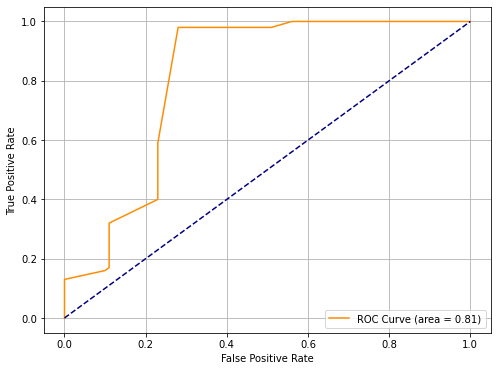

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(FPR, TPR, color='darkorange', label='ROC Curve (area = 0.81)')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.savefig('../pics/roc_curve_sflow.png', bbox_inches='tight')